In [1]:
import numpy as np
import random
import os

# Set a seed value
seed_value = 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

In [8]:
import anndata
from sklearn.cluster import KMeans
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from umap.umap_ import UMAP  # Corrected import for UMAP class
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA


In [9]:
# Load the AnnData object
ann_data = anndata.read_h5ad("mouse_kidney_norn_uce_adata_word2vec.h5ad")
ann_raw = anndata.read_h5ad("mouse_kidney_norn_uce_adata.h5ad") 

In [10]:
## centroid update with UCE
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KernelDensity


def calculate_density(data, n_neighbors=8):
    nn = NearestNeighbors(n_neighbors=n_neighbors)
    nn.fit(data)
    distances, _ = nn.kneighbors(data)
    density = 1 / np.mean(distances, axis=1)
    return density


def calculate_weighted_centroid(points, uce_weights):
    weighted_sum = sum(p * w for p, w in zip(points, uce_weights))
    weight_sum = sum(uce_weights)
    return weighted_sum / weight_sum if weight_sum else None


def update_centroids(clusters, data, use_density=True):
    new_centroids = []
    for cluster_indices in clusters:
        if cluster_indices:  # Check if the cluster is not empty
            points = data[cluster_indices]
            if use_density:
                density = calculate_density(points)
                uce_weights = density # Modulate weights by learning rate
            else:
                uce_weights = np.ones(len(points))
            centroid = calculate_weighted_centroid(points, uce_weights)
            new_centroids.append(centroid)

    # Convert list of centroids to a 2D NumPy array
    new_centroids = np.array(new_centroids)
    return new_centroids

In [11]:

from sklearn.metrics.pairwise import cosine_similarity


def kmeans_plusplus(data, k, max_iter=100, use_density=True):
    # Step 1: Initialize centroids using k-means++ algorithm
    initial_centroids = KMeans(n_clusters=k, init='k-means++', n_init='auto', max_iter=1).fit(data).cluster_centers_
    print(initial_centroids.shape)
    print(initial_centroids)
    clusters = None

    centroids = initial_centroids
    for iteration in range(max_iter):
        # Step 2: Assign points to the nearest centroid
        clusters = [[] for _ in range(k)]
        for i, point in enumerate(data):
            similarities = cosine_similarity([point], centroids)[0]
            closest_centroid_idx = np.argmax(similarities)
            clusters[closest_centroid_idx].append(i)

        # Step 3: Update centroids using the UCE weighted method
        new_centroids = update_centroids(clusters, data, use_density=use_density)

        # Check for convergence
        if np.allclose(new_centroids, centroids):
            break

        centroids = new_centroids

    return centroids, clusters


In [12]:
def evaluate_model(data, kmeans_clusters, CellTypeCol='group'):
    # Prepare the data for UMAP visualization
    all_points = data
    # Flatten the cluster structure for color coding in the plot
    cluster_labels_UCE = np.empty(all_points.shape[0], dtype=int)
    for cluster_idx, points_idx in enumerate(kmeans_clusters):
        for point_idx in points_idx:
            cluster_labels_UCE[point_idx] = cluster_idx

    umap_model = UMAP(n_components=2)
    embedding = umap_model.fit_transform(all_points)
    embedding_df_UCE = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
    embedding_df_UCE['Cluster'] = cluster_labels_UCE

    # do the same for the cell types
    cell_types = ann_data.obs[CellTypeCol].values
    embedding_df_UCE['CellType'] = cell_types  # This adds the actual cell types to your DataFrame

    # Now we group by the 'Cluster' and determine the most common 'CellType' within each cluster
    majority_cell_types = embedding_df_UCE.groupby('Cluster')['CellType'].agg(
        lambda x: np.unique(x, return_counts=True)[0][np.argmax(np.unique(x, return_counts=True)[1])])

    # Map the majority cell type to each point in the DataFrame
    embedding_df_UCE['MajorityCellType'] = embedding_df_UCE['Cluster'].map(majority_cell_types)

    accuracy = accuracy_score(cell_types, embedding_df_UCE['MajorityCellType'])

    return accuracy


In [13]:
import torch
import numpy as np
from scipy.sparse import issparse


def normalize(input, p=2.0, dim=1, eps=1e-12, out=None):
    if out is None:
        denom = input.norm(p, dim, keepdim=True).clamp_min(eps).expand_as(input)
        return input / denom
    else:
        denom = input.norm(p, dim, keepdim=True).clamp_min_(eps).expand_as(input)
        return torch.div(input, denom, out=out)


# Check if `ann_raw.X` is a sparse matrix and convert it to a dense format if it is
if issparse(ann_raw.X):
    dense_data = ann_raw.X.toarray()
else:
    dense_data = ann_raw.X

# Convert the dense data to a PyTorch tensor
ann_raw_X_tensor = torch.tensor(dense_data, dtype=torch.float32)

# Apply the normalization
normalized_data = normalize(ann_raw_X_tensor, p=2.0, dim=1, eps=1e-12)

# `normalized_data` is now the normalized tensor

ann_raw.X = np.ascontiguousarray(normalized_data.numpy())

In [14]:
pca = PCA(n_components=1280)  # Adjust n_components to your needs
principalComponents = pca.fit_transform(ann_raw.X)
# use np.ascontiguousarray
principalComponents = np.ascontiguousarray(principalComponents)

In [15]:
def write_variable_arrays_to_file(*arrays, file_name='variable_arrays_content.txt'):
    with open(file_name, 'w') as file:
        for array in arrays:
            file.write(', '.join(map(str, array)) + '\n')

In [17]:
import time

acc_original_list = []
acc_pca_list = []
acc_word2vec_list = []
acc_uce_list = []

time_original_list = []
time_pca_list = []
time_word2vec_list = []
time_uce_list = []

cluster_nums = range(1, 16) 

for cluster_num in cluster_nums:
    time_start = time.time()
    print(cluster_num)
    kmeans_centroids_original, kmeans_clusters_original = kmeans_plusplus(ann_raw.X, cluster_num, use_density=False)
    acc_original = evaluate_model(ann_raw.X, kmeans_clusters_original)
    time_original = time.time()-time_start
    print("finish_original")
    time_start = time.time()
    kmeans_centroids_pca, kmeans_clusters_pca = kmeans_plusplus(principalComponents, cluster_num, use_density=False)
    acc_pca = evaluate_model(principalComponents, kmeans_clusters_pca)
    time_pca = time.time()-time_start
    print("finish_pca")
    time_start = time.time()
    kmeans_centroids_word2vec, kmeans_clusters_word2vec = kmeans_plusplus(ann_data.obsm['word2vec'], cluster_num, use_density=False)
    acc_word2vec = evaluate_model(ann_data.obsm['word2vec'], kmeans_clusters_word2vec)
    time_word2vec = time.time()-time_start
    print("finish_word2vec")
    time_start = time.time()
    kmeans_centroids_uce, kmeans_clusters_uce = kmeans_plusplus(ann_data.obsm['X_uce'], cluster_num, use_density=False)
    acc_uce = evaluate_model(ann_data.obsm['X_uce'], kmeans_clusters_uce)
    time_uce = time.time()-time_start
    print("finish_uce")
    acc_original_list.append(acc_original)
    acc_pca_list.append(acc_pca)
    acc_word2vec_list.append(acc_word2vec)
    acc_uce_list.append(acc_uce)
    
    time_original_list.append(time_original)
    time_pca_list.append(time_pca)
    time_word2vec_list.append(time_word2vec)
    time_uce_list.append(time_uce)

1
(1, 14751)
[[7.5563532e-04 6.9742557e-04 1.5405696e-03 ... 1.9092593e-01
  1.4151027e-04 1.0507712e-01]]
finish_original
(1, 1280)
[[ 7.4314931e-07 -4.2780411e-07  2.7839383e-07 ... -9.2829993e-09
  -3.2008121e-09 -1.5814294e-08]]
finish_pca
(1, 1280)
[[-0.05782691  0.0700269   0.07889026 ... -0.03602382  0.01020514
  -0.00679524]]
finish_word2vec
(1, 1280)
[[ 0.01874538 -0.02234781 -0.0113524  ... -0.01535439  0.00476144
  -0.0009526 ]]
finish_uce
2
(2, 14751)
[[6.8091368e-04 7.1485556e-04 1.4843395e-03 ... 2.0164439e-01
  1.5221360e-04 1.0926383e-01]
 [1.4972377e-03 5.2443816e-04 2.0986227e-03 ... 8.4548451e-02
  3.5280558e-05 6.3525349e-02]]
finish_original
(2, 1280)
[[-2.0699768e-01  2.1787322e-01  6.5793514e-02 ...  9.6411350e-05
  -3.0766310e-05 -1.1251100e-04]
 [ 2.6348496e-02 -2.7732413e-02 -8.3742058e-03 ... -1.2282249e-05
   3.9124538e-06  1.4303055e-05]]
finish_pca
(2, 1280)
[[-0.10729074  0.12625213  0.06153769 ... -0.07187928  0.13761857
   0.01693571]
 [-0.04468919  0.0

In [18]:
write_variable_arrays_to_file(acc_original_list, acc_pca_list,acc_word2vec_list,acc_uce_list, file_name="acc.txt")

write_variable_arrays_to_file(time_original_list, time_pca_list,time_word2vec_list,time_uce_list, file_name="time.txt")

In [19]:
import time

acc_original_list_with_density = []
acc_pca_list_with_density = []
acc_word2vec_list_with_density = []
acc_uce_list_with_density = []

time_original_list_with_density = []
time_pca_list_with_density = []
time_word2vec_list_with_density = []
time_uce_list_with_density = []

cluster_nums = range(1, 16) 

for cluster_num in cluster_nums:
    time_start = time.time()
    print(cluster_num)
    kmeans_centroids_original_with_density, kmeans_clusters_original_with_density = kmeans_plusplus(ann_raw.X, cluster_num)
    acc_original_with_density = evaluate_model(ann_raw.X, kmeans_clusters_original_with_density)
    time_original_with_density = time.time()-time_start
    print("finish_original")
    time_start = time.time()
    kmeans_centroids_pca_with_density, kmeans_clusters_pca_with_density = kmeans_plusplus(principalComponents, cluster_num)
    acc_pca_with_density = evaluate_model(principalComponents, kmeans_clusters_pca_with_density)
    time_pca_with_density = time.time()-time_start
    print("finish_pca")
    time_start = time.time()
    kmeans_centroids_word2vec_with_density, kmeans_clusters_word2vec_with_density = kmeans_plusplus(ann_data.obsm['word2vec'], cluster_num)
    acc_word2vec_with_density = evaluate_model(ann_data.obsm['word2vec'], kmeans_clusters_word2vec_with_density)
    time_word2vec_with_density = time.time()-time_start
    print("finish_word2vec")
    time_start = time.time()
    kmeans_centroids_uce_with_density, kmeans_clusters_uce_with_density = kmeans_plusplus(ann_data.obsm['X_uce'], cluster_num)
    acc_uce_with_density = evaluate_model(ann_data.obsm['X_uce'], kmeans_clusters_uce_with_density)
    time_uce_with_density = time.time()-time_start
    print("finish_uce")
    acc_original_list_with_density.append(acc_original_with_density)
    acc_pca_list_with_density.append(acc_pca_with_density)
    acc_word2vec_list_with_density.append(acc_word2vec_with_density)
    acc_uce_list_with_density.append(acc_uce_with_density)
    
    time_original_list_with_density.append(time_original_with_density)
    time_pca_list_with_density.append(time_pca_with_density)
    time_word2vec_list_with_density.append(time_word2vec_with_density)
    time_uce_list_with_density.append(time_uce_with_density)

1
(1, 14751)
[[7.5563532e-04 6.9742557e-04 1.5405696e-03 ... 1.9092593e-01
  1.4151027e-04 1.0507712e-01]]
finish_original
(1, 1280)
[[ 7.4362833e-07 -4.2817669e-07  2.7865167e-07 ... -9.2829993e-09
  -3.2014360e-09 -1.5812214e-08]]
finish_pca
(1, 1280)
[[-0.05782691  0.0700269   0.07889026 ... -0.03602382  0.01020514
  -0.00679524]]
finish_word2vec
(1, 1280)
[[ 0.01874538 -0.02234781 -0.0113524  ... -0.01535439  0.00476144
  -0.0009526 ]]
finish_uce
2
(2, 14751)
[[8.93036020e-04 7.79792608e-04 1.76586665e-03 ... 2.72877961e-02
  4.43797035e-05 4.93205711e-02]
 [7.42254138e-04 6.89403503e-04 1.51862507e-03 ... 2.06862271e-01
  1.50969354e-04 1.10507116e-01]]
finish_original
(2, 1280)
[[ 6.0716160e-03 -1.3170745e-04 -1.1087857e-03 ... -7.4169787e-07
  -1.2831860e-07  3.7905008e-06]
 [-2.7681199e-01  5.9854072e-03  5.0570138e-02 ...  3.3385022e-05
   5.7033499e-06 -1.7357159e-04]]
finish_pca
(2, 1280)
[[-0.07336895  0.09008989  0.07247766 ... -0.06568184  0.06139725
  -0.00267413]
 [-0.0

In [20]:
write_variable_arrays_to_file(acc_original_list_with_density, acc_pca_list_with_density,acc_word2vec_list_with_density,acc_uce_list_with_density, file_name="acc_with_density.txt")

write_variable_arrays_to_file(time_original_list_with_density, time_pca_list_with_density,time_word2vec_list_with_density,time_uce_list_with_density, file_name="time_with_density.txt")

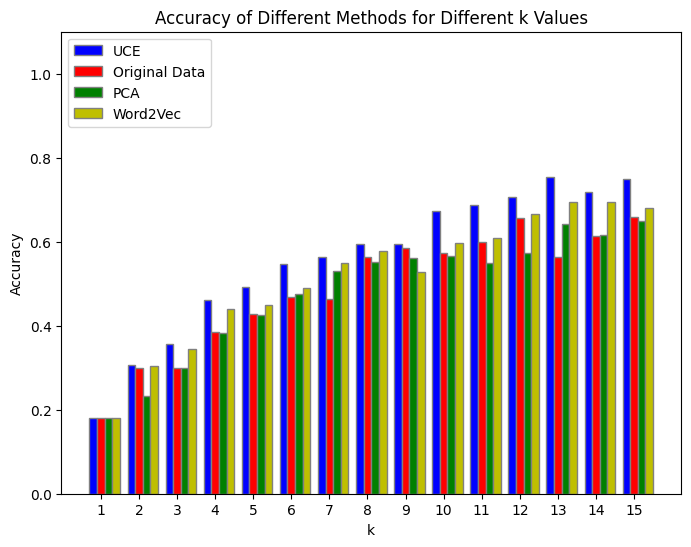

In [21]:
plt.figure(figsize=(8, 6))
barWidth = 0.2
r1 = np.arange(len(cluster_nums))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

plt.bar(r1, acc_uce_list, color='b', width=barWidth, edgecolor='grey', label='UCE')
plt.bar(r2, acc_original_list, color='r', width=barWidth, edgecolor='grey', label='Original Data')
plt.bar(r3, acc_pca_list, color='g', width=barWidth, edgecolor='grey', label='PCA')
plt.bar(r4, acc_word2vec_list, color='y', width=barWidth, edgecolor='grey', label='Word2Vec')

plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Methods for Different k Values')
plt.xticks([r + barWidth for r in range(len(cluster_nums))], cluster_nums)
# make the legend not on top of the bars
plt.legend(loc='upper left')
# add space at the top of the plot
plt.ylim(0, 1.1)

plt.show()

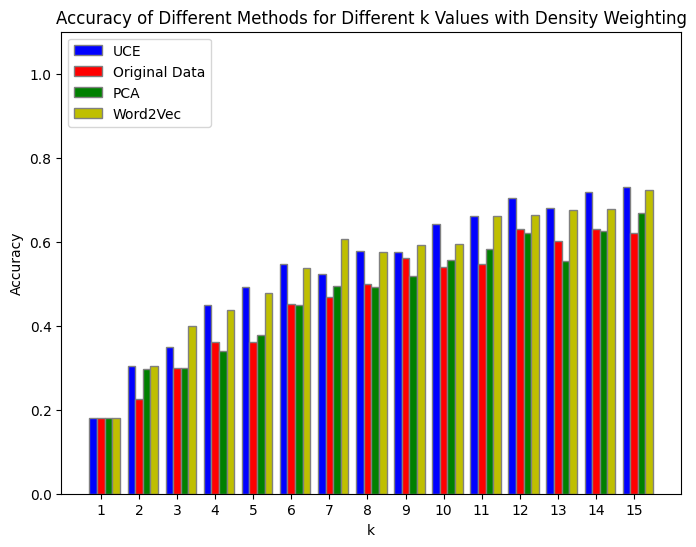

In [22]:
# i want histograms for each k - we will have k = 8, 9, 10 as x and y will be accuracy and for each k we will have 4 bars for each method

plt.figure(figsize=(8, 6))
barWidth = 0.2
r1 = np.arange(len(cluster_nums))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

plt.bar(r1, acc_uce_list_with_density, color='b', width=barWidth, edgecolor='grey', label='UCE')
plt.bar(r2, acc_original_list_with_density, color='r', width=barWidth, edgecolor='grey', label='Original Data')
plt.bar(r3, acc_pca_list_with_density, color='g', width=barWidth, edgecolor='grey', label='PCA')
plt.bar(r4, acc_word2vec_list_with_density, color='y', width=barWidth, edgecolor='grey', label='Word2Vec')

plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Methods for Different k Values with Density Weighting')
plt.xticks([r + barWidth for r in range(len(cluster_nums))], cluster_nums)
# make the legend not on top of the bars
plt.legend(loc='upper left')
# add space at the top of the plot
plt.ylim(0, 1.1)

plt.show()

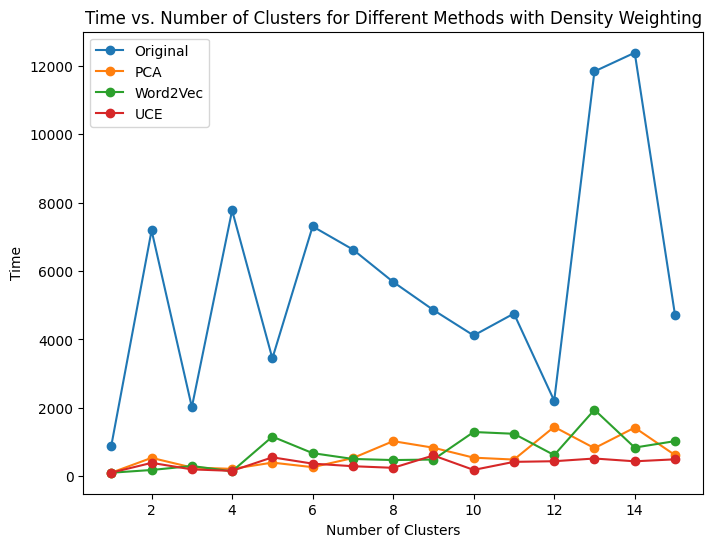

In [23]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(cluster_nums, time_original_list_with_density, marker='o', label='Original')
plt.plot(cluster_nums, time_pca_list_with_density, marker='o', label='PCA')
plt.plot(cluster_nums, time_word2vec_list_with_density, marker='o', label='Word2Vec')
plt.plot(cluster_nums, time_uce_list_with_density, marker='o', label='UCE')

# Adding labels and title
plt.xlabel('Number of Clusters')
plt.ylabel('Time')
plt.title('Time vs. Number of Clusters for Different Methods with Density Weighting')
plt.legend()

# Display the plot
plt.show()


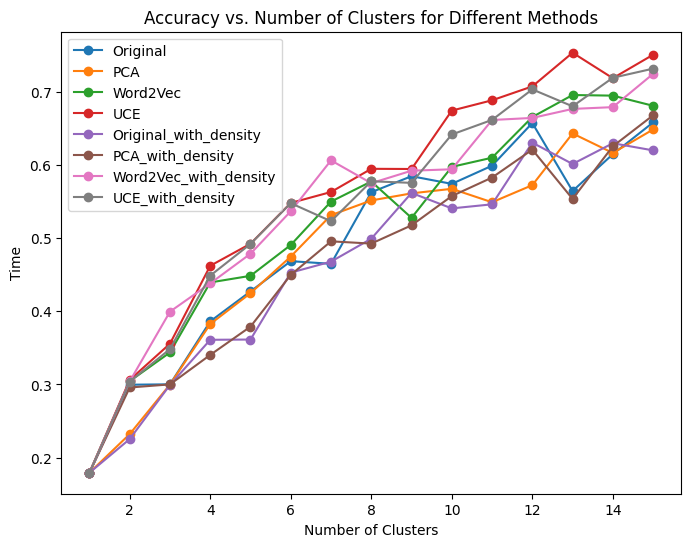

In [24]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(cluster_nums, acc_original_list, marker='o', label='Original')
plt.plot(cluster_nums, acc_pca_list, marker='o', label='PCA')
plt.plot(cluster_nums, acc_word2vec_list, marker='o', label='Word2Vec')
plt.plot(cluster_nums, acc_uce_list, marker='o', label='UCE')

plt.plot(cluster_nums, acc_original_list_with_density, marker='o', label='Original_with_density')
plt.plot(cluster_nums, acc_pca_list_with_density, marker='o', label='PCA_with_density')
plt.plot(cluster_nums, acc_word2vec_list_with_density, marker='o', label='Word2Vec_with_density')
plt.plot(cluster_nums, acc_uce_list_with_density, marker='o', label='UCE_with_density')


# Adding labels and title
plt.xlabel('Number of Clusters')
plt.ylabel('Time')
plt.title('Accuracy vs. Number of Clusters for Different Methods')
plt.legend()

# Display the plot
plt.show()


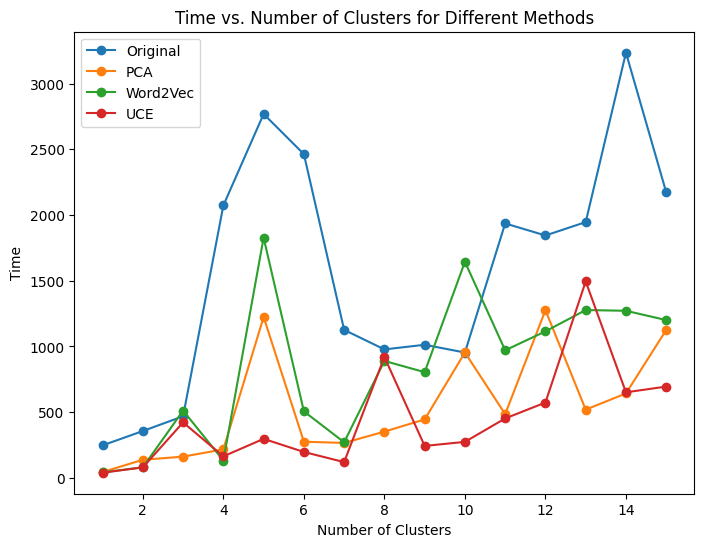

In [25]:
import matplotlib.pyplot as plt
cluster_nums = range(1, 16) 
# Plotting
plt.figure(figsize=(8, 6))
plt.plot(cluster_nums, time_original_list, marker='o', label='Original')
plt.plot(cluster_nums, time_pca_list, marker='o', label='PCA')
plt.plot(cluster_nums, time_word2vec_list, marker='o', label='Word2Vec')
plt.plot(cluster_nums, time_uce_list, marker='o', label='UCE')

# Adding labels and title
plt.xlabel('Number of Clusters')
plt.ylabel('Time')
plt.title('Time vs. Number of Clusters for Different Methods')
plt.legend()

# Display the plot
plt.show()


In [26]:
len(cluster_nums)

15